## Traffic Light classification (Model Pipeline)

This classification is part from System Intergraion Project (Self-Driving Car Engineer Nanodegree Udacity) and this notebook will take you in the journey of this task step-by-step.

Outlines:
* Step 0a: Imports libraries
* Step 0b: Load The Data
* Step 1a: Form tidy dataset X and Y
* Step 1b: Dataset Summary & Exploration
* Step 2: Data augmentation and samples generation
* Step 3: CNN arechtecture and training
* Step 4: Evaluate/test model
* Step 5: Visualization of model results 
---
References: 
* Steps 0b taken from @jensen notebook [here](https://github.com/andrewraharjo/CarND-Final_Project/blob/master/ros/src/tl_detector/training/model.ipynb) 
* Traffic light detection with color and edge information [here](http://ieeexplore.ieee.org/document/5234518/)
* Real-time recognition system of traffic light in urban environment [here](http://ieeexplore.ieee.org/document/6291516/)

___
### Step 0a: Imports libraries 

In [1]:
#Imports 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle #
from pandas.io.parsers import read_csv
import pandas as pd
import pickle
import time
from datetime import timedelta #
import math
import os
from scipy import ndimage #
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from scipy import misc
import glob
import cv2
import matplotlib

##Import keras layers
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda, ELU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import model_from_json
#import keras.backend as K #to define custom metrices for callback

import json
import csv
%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


---
### Step 0b: Load The Data

In [2]:
# Create lists of image filenames:
green_images_1 = glob.glob('data/bag_dump_just_traffic_light/green/*.jpg')
green_images_2 = glob.glob('data/bag_dump_loop_with_traffic_light/green/*.jpg')
yellow_images_1 = glob.glob('data/bag_dump_just_traffic_light/yellow/*.jpg')
yellow_images_2 = glob.glob('data/bag_dump_loop_with_traffic_light/yellow/*.jpg')
red_images_1 = glob.glob('data/bag_dump_just_traffic_light/red/*.jpg')
red_images_2 = glob.glob('data/bag_dump_loop_with_traffic_light/red/*.jpg')
no_light_images_1 = glob.glob('data/bag_dump_just_traffic_light/nolight/*.jpg') 
no_light_images_2 = glob.glob('data/bag_dump_loop_with_traffic_light/nolight/*.jpg')

# Image shape that we want to form all images in.
shape= [64,64,3]

---
### Step 1a: Form tidy dataset X and Y   
form X,Y (later we will split them to trainX and ValidationX , trainY and validationY)

In [3]:
## From X contain images path and  Y  contain class id
g1 = pd.DataFrame(green_images_1, columns = ['path']) 
g2 =  pd.DataFrame(green_images_2, columns = ['path'])
g= pd.concat([g1.path, g2.path ], ignore_index=True)
gy = [2]* 456
gy = pd.DataFrame(gy)
#print("gy:",gy.shape[0])
y1 = pd.DataFrame(yellow_images_1, columns = ['path']) 
y2 =  pd.DataFrame(yellow_images_2, columns = ['path'])
y= pd.concat([y1.path, y2.path ], ignore_index=True)
yy = [1]* 131
yy = pd.DataFrame(yy)
#print("yy:",yy.shape[0])
r1 = pd.DataFrame(red_images_1, columns = ['path']) 
r2 =  pd.DataFrame(red_images_2, columns = ['path'])
r= pd.concat([r1.path, r2.path ], ignore_index=True)
ry = [0]* 332
ry = pd.DataFrame(ry)
#print("ry:",ry.shape[0])
nl1 = pd.DataFrame(no_light_images_1, columns = ['path']) 
nl2 =  pd.DataFrame(no_light_images_2, columns = ['path'])
nl= pd.concat([nl1.path, nl2.path ], ignore_index=True)
nly = [3]* 874
nly = pd.DataFrame(nly)
#print("nly:",nly.shape[0])
X = pd.concat([g,y,r,nl],     ignore_index=True)
Y = pd.concat([gy[0],yy[0],ry[0],nly[0]], ignore_index=True)
#class names 
Ynames  = ['red', 'yellow', 'green', 'no light']
nclass=4
nsamples =  len(X) 

In [4]:
#shuffle function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b) 
    p = np.random.permutation(len(a))
    return a[p], b[p] 

#run function with X and Y
X,Y = unison_shuffled_copies(X, Y)


In [5]:
##split (train set and validation set) ,Shuffle train se) and form sets to array
#split
tX, vX, tY, vY = train_test_split(X, Y, test_size=0.20, random_state=42)
#as array
tX = np.array(tX)
vX = np.array(vX)
tY = np.array(tY)
vY = np.array(vY)

tY = to_categorical(tY)
vY = to_categorical(vY)


print("Train img Shape",tX.shape)
print("train steering Shape",tY.shape)
print("validation img Shape",vX.shape)
print("validation steering Shape",vY.shape)
#print(tX[0:5])
#print(tY[0:5])
print(tY.shape,vY.shape)

Train img Shape (1434,)
train steering Shape (1434, 4)
validation img Shape (359,)
validation steering Shape (359, 4)
(1434, 4) (359, 4)


---
### Step 1b: Dataset Summary & Exploration

In [6]:
print("                   Summary of Dataset     ")
print("_____________________________________________________________")
print("Number of Green TL class samples is:",len(g1))
print("Number of Green TL (with loop) class samples is:",len(g2))
print("Number of Yellow TL class samples is:",len(y1))
print("Number of Yellow (with loop) TL class samples is:",len(y2))
print("Number of red TL class samples is:",len(r1))
print("Number of red (with loop) TL class samples is:",len(r2))
print("Number of no light TL class samples is:",len(nl1))
print("Number of no light (with loop) TL class samples is:",len(nl2))
print("=============================================================")
print("Number of all Green TL class samples is:",len(g))
print("Number of all Yellow TL class samples is:",len(y))
print("Number of all red TL class samples is:",len(r))
print("Number of all no light TL class samples is:",len(nl))
print("====> We have ",nclass, " classes with", nsamples, "Samples <====")
print("training X shape is ", tX.shape , "Validation X shape is: ", vX.shape)
print("training Y shape is ", tY.shape , "Validation Y shape is: ", vY.shape)

                   Summary of Dataset     
_____________________________________________________________
Number of Green TL class samples is: 325
Number of Green TL (with loop) class samples is: 131
Number of Yellow TL class samples is: 131
Number of Yellow (with loop) TL class samples is: 0
Number of red TL class samples is: 186
Number of red (with loop) TL class samples is: 146
Number of no light TL class samples is: 62
Number of no light (with loop) TL class samples is: 812
Number of all Green TL class samples is: 456
Number of all Yellow TL class samples is: 131
Number of all red TL class samples is: 332
Number of all no light TL class samples is: 874
====> We have  4  classes with 1793 Samples <====
training X shape is  (1434,) Validation X shape is:  (359,)
training Y shape is  (1434, 4) Validation Y shape is:  (359, 4)


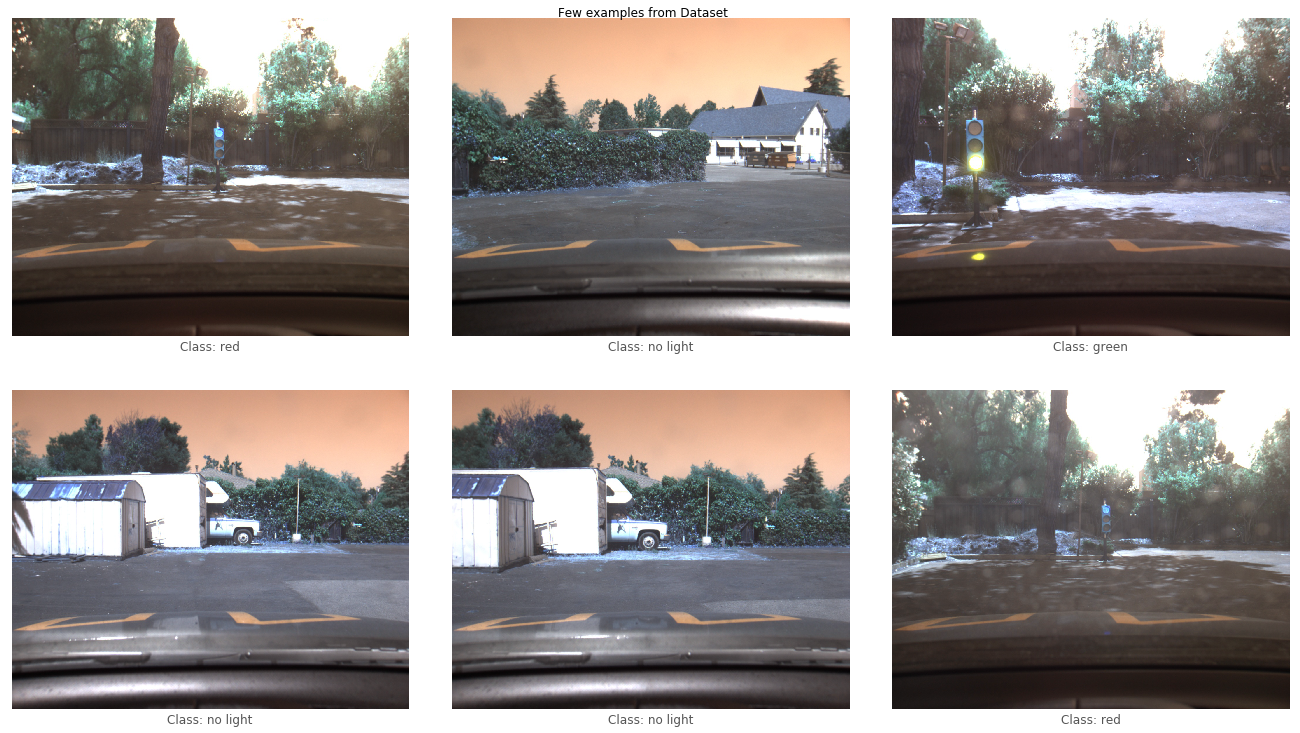

In [7]:

##Function to plot examples from data
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 6
    
    # Create figure with 2x2 sub-plots.
    fig, axes = plt.subplots(2,3)
    #fig.subplots_adjust(hspace=0.3, wspace=3)
    fig.set_size_inches(18.5, 10.5)

    fig.tight_layout()
    # set title
    fig.suptitle('Few examples from Dataset')
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.imread(images[i])
        ax.imshow(image, cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Class: {0}".format(Ynames[np.argmax(cls_true[i])])
            

        else:
            xlabel = " Class: {0},  Pred: {1}".format(Ynames[np.argmax(cls_true[i])],Ynames[np.argmax(cls_pred[i])])


        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        
        ax.set_xticks([])
        ax.set_yticks([])
        

    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
plot_images(images= tX[0:6], cls_true=tY[0:6])


class  green
(1096, 1368, 3)
(646, 1368, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


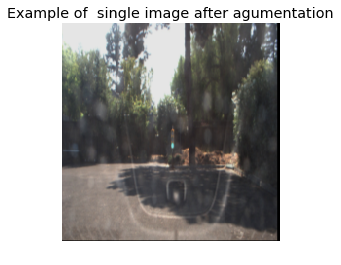

In [8]:
# Example of  single image after each agumentation (comment each line to see the difference) :
exNumber = 4
print("class ", Ynames[Y[exNumber]])
img = cv2.imread(str(X[exNumber]))
print(img.shape)

#color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#crop
img = img[100:img.shape[0]-350, 0:img.shape[1]]
print(img.shape)
    
# Resize the image
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
print(img.shape)

#flip
img = cv2.flip(img, 1)
print(img.shape)

#random brightness
img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
random_bright = 0.8 + 0.4*(2*np.random.uniform()-1.0)    
img[:,:,2] = img[:,:,2]*random_bright
img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
print(img.shape)

#norm
def norm(img, ra=0.9, rb=0.1):
    Max = np.max(img)
    Min = np.min(img)
    img = (ra - rb) * (img - Min) / (Max - Min) + rb
    return img
img  = norm(img, ra=0.9, rb=0.1)
print(img.shape)

#translate/random shift in horizontal direction
rows, cols, _ = img.shape
tr_x = 20 * np.random.uniform() - 20/2
tr_y = 10 * np.random.uniform() - 10/2
Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
img = cv2.warpAffine(img, Trans_M, (cols, rows))


print(img.shape)

plt.title('Example of  single image after agumentation')
plt.imshow(img)
plt.axis("off")
plt.show()

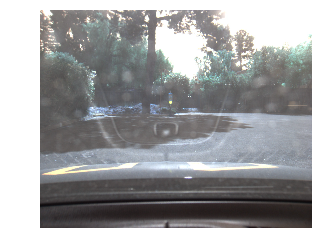

data/bag_dump_just_traffic_light/green\left0004.jpg


In [9]:
#without resize and agumentation
imag = cv2.imread(X[4])
plt.imshow(imag)
plt.axis("off")
plt.show()
print(X[4])

---
### Step 2: Data augmentation

In [10]:
##Preprocess Functions
"""
Preprocss functions 
1- cropresize(img): 
Crop non important parts from an image (img) and retain only the track, Then Resize the image to 64*64 dimensions 

2- change_colorspace(img, color_space='RGB'):
change from RGB mode to YUV

3- flipped_image(img, steering):
flip image (img) horizontally then reverse the steering angle (steering)

4-brightnessed_image(img):
set random brightness to the image (img)

5- norm(img, ra=0.9, rb=0.1): 
Normalization of dataset for each image

6- translated_image(img, steering):
to generate fair dataset (normal distrebution) generate a new image 
from the current image(img) using random shift in horizontal direction. 
with change in the steering angle (steering) value is 0.4 per pixel

7- image_augmentation(img, steering):
apply flipped_image with 50% chance then apply Brightness and tranlslate functions 
""" 
#cropresize
def cropresize(img):  
    # crop non important parts and retain only the track
    roi = img[100:img.shape[0]-350, 0:img.shape[1]]
    
    # Resize the image
    resize = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
    return resize

def norm(img, ra=0.9, rb=0.1):
    Max = np.max(img)
    Min = np.min(img)
    img = (ra - rb) * (img - Min) / (Max - Min) + rb
    return img

def change_colorspace(img, color_space='RGB'):
    if color_space == 'RGB':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if color_space == 'YCrCb':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else:
        img = np.copy(img)
    img = norm(img, ra=0.9, rb=0.1)
    
    return img
    
def flipped_image(img):
    img = cv2.flip(img, 1)
    return img

def brightnessed_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = 0.8 + 0.4*(2*np.random.uniform()-1.0)    
    img[:,:,2] = img[:,:,2]*random_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img


def translated_image(img):
    rows, cols, _ = img.shape
    tr_x = 20 * np.random.uniform() - 20/2
    tr_y = 10 * np.random.uniform() - 10/2
    Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    return img


def image_augmentation(img):
    if np.random.uniform() < 0.5:
        img = flipped_image(img)
    #img = brightnessed_image(img)
    img = norm(img, ra=0.9, rb=0.1)
    img = translated_image(img)
    
    return img


############################################################################

##Process  (read + augmentation + transform to 64*64)
#Process Train img 
def readTrainimage(img,Y):
    # Let's read the image
    img = cv2.imread(img)  # Read in the image
    img = change_colorspace(img, color_space='RGB')
    img = cropresize(img)  # Crop and resize the image
    img = image_augmentation(img) 
    # change colorspace:
    return img, Y

#Process Valid img
def readValidimage(img,Y):
    # Let's read the image
    #folderpath = "data/"
    #img = cv2.imread(folderpath+img.strip(' '))  # Read in the image
    img = cv2.imread(img)  # Read in the image
    img = cropresize(img)  # Crop and resize the image
    # change colorspace:
    img = change_colorspace(img, color_space='RGB')
    return img, Y

In [11]:
##Generate  samples from training and validation sets
#for train set
def traingenerator(img, Y, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 224, 224, 3))
    batch_labels = np.zeros((batch_size,4)) #,1
    while True:
        for i in range(batch_size):
            #choose random index in features
            index = np.random.randint(0, len(img))
            batch_features[i], batch_labels[i] = readTrainimage(img[index],Y[index]) 
        yield batch_features, batch_labels

#for validset        
def Validgenerator(img, Y, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 224, 224, 3))
    batch_labels = np.zeros((batch_size,4)) #,1
    while True:
        for i in range(batch_size):
            #choose random index in features
            index= np.random.randint(0,len(img))
            batch_features[i], batch_labels[i] =readValidimage(img[index],Y[index]) 
        yield batch_features, batch_labels



___
### Step 3: CNN arechtecture and training

1321 no light
Returned batch size: 224
Returned image shape: (224, 3)


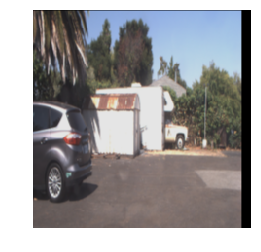

In [12]:
##Test/Demo

index = np.random.randint(0, len(tX))
print(index, Ynames[np.argmax(tY[index])])
batch_features, batch_labels = readTrainimage(tX[index], tY[index]) 
print('Returned batch size: {}'.format(len(batch_features))) 
print('Returned image shape: {}'.format(batch_features[0].shape))
plt.imshow(batch_features)
plt.axis('off')
plt.show()

In [58]:
#input_shape = (64, 64, 3)
#def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(4, name='output', init='he_normal')) #dense(1,)...
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])  #mse old
    return model
#modele = get_model()
#modele.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 64, 64, 3)     0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
conv0 (Convolution2D)            (None, 64, 64, 3)     12          lambda_11[0][0]                  
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 62, 62, 32)    896         conv0[0][0]                      
____________________________________________________________________________________________________
elu_91 (ELU)                     (None, 62, 62, 32)    0           conv1[0][0]                      
___________________________________________________________________________________________

In [14]:
##Train
model = get_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_object= modele.fit_generator(
    traingenerator(tX, tY, 32),
    samples_per_epoch=960,
    nb_epoch=20,
    validation_data=Validgenerator(vX, vY, 250),
    nb_val_samples=500,
    callbacks=[ModelCheckpoint(filepath="v3model.h5", verbose=1, save_best_only=True)])


#model.evaluate(X=predictor_train, y=target_train,batch_size=batch,show_accuracy=True)

Epoch 1/20
960/960 [==============================] - 305s - loss: 1.1912 - acc: 0.4896 - val_loss: 1.1307 - val_acc: 0.4660
Epoch 2/20
960/960 [==============================] - 206s - loss: 0.8463 - acc: 0.6698 - val_loss: 0.6984 - val_acc: 0.7760
Epoch 3/20
960/960 [==============================] - 189s - loss: 0.7046 - acc: 0.6906 - val_loss: 0.6138 - val_acc: 0.7740
Epoch 4/20
960/960 [==============================] - 184s - loss: 0.5309 - acc: 0.7698 - val_loss: 0.4532 - val_acc: 0.7840
Epoch 5/20
960/960 [==============================] - 183s - loss: 0.4938 - acc: 0.7948 - val_loss: 0.4181 - val_acc: 0.8720
Epoch 6/20
960/960 [==============================] - 193s - loss: 0.4746 - acc: 0.8167 - val_loss: 0.3346 - val_acc: 0.8620
Epoch 7/20
960/960 [==============================] - 172s - loss: 0.3102 - acc: 0.8938 - val_loss: 0.2969 - val_acc: 0.9440
Epoch 8/20
960/960 [==============================] - 177s - loss: 0.2567 - acc: 0.9083 - val_loss: 0.2289 - val_acc: 0.9280


---
### Step 4: Evaluate/test model + Save

In [15]:
## validation accuracy
print("The validation accuracy is: %.3f" % history_object.history['val_acc'][-1])

The validation accuracy is: 0.986


In [16]:
##Save Model

# serialize model to JSON
modele_json = modele.to_json()
with open("model.json", "w") as json_file:
    json_file.write(modele_json)
# serialize weights to HDF5
modele.save_weights("modele.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
## Load Model
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modele.h5")
print("Loaded model from disk")

Loaded model from disk


(1096, 1368, 3)
(646, 1368, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(1, 224, 224, 3)


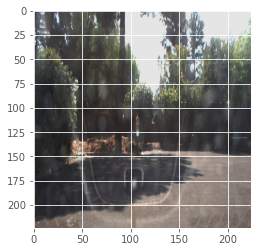

red:  0.00820058
yellow:  0.00358784
green:  0.98748
no light:  0.000731902


In [43]:

greenSample = X[0]
image = cv2.imread(greenSample)
print(image.shape)

#color space
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#crop
img = img[100:img.shape[0]-350, 0:img.shape[1]]
print(img.shape)
    
# Resize the image
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
print(img.shape)



#norm
def norm(img, ra=0.9, rb=0.1):
    Max = np.max(img)
    Min = np.min(img)
    img = (ra - rb) * (img - Min) / (Max - Min) + rb
    return img
img  = norm(img, ra=0.9, rb=0.1)
print(img.shape)
img = np.array([img])
print(img.shape)

# change colorspace:
#X = change_colorspace(X, color_space='RGB')
#X = norm(X, ra=0.9, rb=0.1)
plt.imshow(img[0])
plt.show()
prediction = loaded_model.predict(img, batch_size=1, verbose=0)
print("red: " , prediction[0][0])
print("yellow: " , prediction[0][1])
print("green: " , prediction[0][2])
print("no light: " , prediction[0][3])

#vX[0]

In [40]:
#Function to generate random test set
def testgenerator(img, Y, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 224, 224, 3))
    batch_labels = np.zeros((batch_size,4)) #,1
    for i in range(batch_size):
        #choose random index in features
        index= np.random.randint(0,len(img))
        batch_features[i], batch_labels[i] =readValidimage(img[index],Y[index]) 
    return batch_features, batch_labels

tstX , tstY = testgenerator(vX, vY, batch_size = 1)
print(tstX.shape)
print(tstY.shape)

tstX= np.swapaxes(tstX, 1, 2)
scores = modele.evaluate(tstX , tstY, verbose=0, batch_size = 32)
#modele.metrics_names[1]
print("%s: %.2f%%" % (modele.metrics_names[1], scores[1]*100))
#scores


(1, 224, 224, 3)
(1, 4)
acc: 100.00%


---
### Step 5: Visualization of model results 

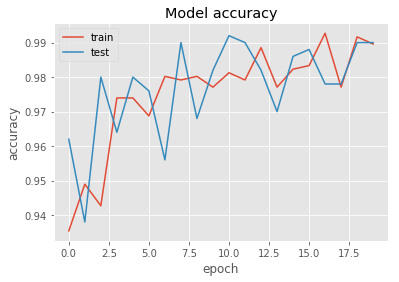

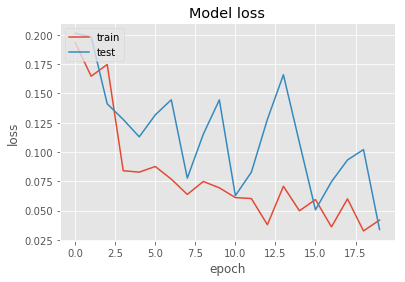

In [146]:
# list all data in history
#print(history_object.history.keys())

# summarize history for accuracy
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test cases

* Make image shape 224,224,3       (~99% acc)
* make colorspace Ycrcb            (not tried yet)
* delte brightness and translation (not tried all of them)

